<a href="https://colab.research.google.com/github/dmed10/HepatitisC-Project/blob/main/Bloom_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install imbalanced-learn

In [ ]:
#imported all my libraries
from category_encoders import OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/Bloom Project

/content/gdrive/MyDrive/Bloom Project


In [ ]:
# !unzip \*.zip  && rm *.zip

In [ ]:
!ls

HepatitisCdata.csv


In [ ]:
#Read in my CSV
df = pd.read_csv('HepatitisCdata.csv', index_col='Unnamed: 0')

In [ ]:
#Check the shape of my dataframe
df.shape

(615, 13)

In [ ]:
#Display the head of my dataframe
df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [ ]:
#Converting my categorical columns into 1 & 0

df['Category'] = [1 if x == '1=Hepatitis' else 0 for x in df['Category']]

df['Sex'] = [0 if x == 'm' else 1 for x in df['Sex']]

In [ ]:
df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0,32,0,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,0,32,0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,0,32,0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,0,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,0,32,0,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [ ]:
df['Category'].value_counts()

0    591
1     24
Name: Category, dtype: int64

In [ ]:
df['Category'].value_counts(normalize=True)

0    0.960976
1    0.039024
Name: Category, dtype: float64

In [ ]:
target = 'Category'
X = df.drop(columns=target)
y = df[target]

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
ros = RandomOverSampler(sampling_strategy=1)
X_sm, y_sm = ros.fit_resample(X, y)

In [ ]:
X_train, X_test, X_val, y_val = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42,)

In [ ]:
# sm = SMOTE(random_state=42)
# X_sm, y_sm = sm.fit_resample(X, y)

In [ ]:
X_train.shape

(945, 12)

In [ ]:
y_train.shape

(492,)

In [ ]:
y_val.shape

(237,)

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.9695121951219512


In [ ]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=25)
)

model_rf.fit(X_train, y_train)

In [ ]:
print('Training Accuracy:', model_rf.score(X_train, y_train))
print('Test Accuracy:', model_rf.score(X_val, y_val))

Training Accuracy: 0.9979674796747967
Test Accuracy: 0.943089430894309


In [ ]:
param_grid = {
    'simpleimputer__strategy':['mean', 'median'],
    'randomforestclassifier__max_depth': range(4, 40, 5),
    'randomforestclassifier__n_estimators': range(25,125,25)
}

In [ ]:
model_rs = RandomizedSearchCV(
    model_rf,
    param_distributions = param_grid,
    cv = None,
    n_jobs = -1,
    verbose = -1,
    n_iter = 35
)

model_rs.fit(X_val, y_val)
val_acc = model_rs.best_score_
print('Accuracy Score:', val_acc)

Accuracy Score: 0.9353333333333333


In [ ]:
model_rs.best_params_

{'randomforestclassifier__max_depth': 14,
 'randomforestclassifier__n_estimators': 25,
 'simpleimputer__strategy': 'median'}

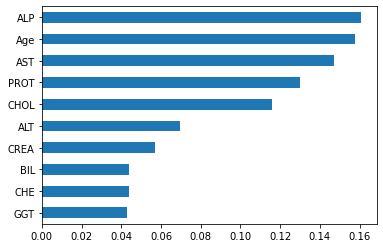

In [ ]:
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh') 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


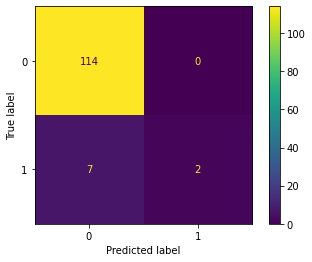

In [ ]:
plot_confusion_matrix(
    model_rf,
    X_val,
    y_val,
    values_format='.0f'
)

In [ ]:
# recall = 2 / (2+7)
# print(recall)

In [ ]:
print(classification_report(y_val,
                      model_rf.predict(X_val),
                      target_names = ['Hepatitis', 'No Hepatitis']))

              precision    recall  f1-score   support

   Hepatitis       0.94      1.00      0.97       114
No Hepatitis       1.00      0.22      0.36         9

    accuracy                           0.94       123
   macro avg       0.97      0.61      0.67       123
weighted avg       0.95      0.94      0.93       123

